# This notebook is to build methods to quantify network quality

# Table of contents
## <a href='#Evaluation-1:-scale-free-network-assumption'>1. Scale free check</a>
## <a href='#Evaluation-2:-compare-network-distance-by-GED-and-deltacon'>2. Compare network distance</a>
## <a href='#Evaluation-3:-compare-network-modules-by-Jaccard'>3. Compare netowrk modules</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import community
import netcomp
import netrd
import time
from networkx.algorithms.community import greedy_modularity_communities
import community
from itertools import combinations
from matplotlib import gridspec
from sknetwork.clustering import Louvain
import matplotlib.pyplot as plt
%matplotlib inline

# Evaluate network quality with edge filtering

In [59]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)
# tom_df = pd.read_csv('/Volumes/GoogleDrive/Shared drives/NIAAA_ASSIST/Data/Kapoor_TOM.csv', index_col = 0)

In [39]:
tom_df_subset = tom_df.iloc[:3000,:3000]

In [41]:
tom_df_subset.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\tom_subset.csv')

# Evaluation 1: scale-free network assumption

In [146]:
def subset_network1(network_df, weight_min, weight_max, num_edges):
    '''
    A function to subset a network using weight cutoff and num_edges
    Return the edgelist and the graph with the edges removed from the cutoff
    '''
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    subset_adj = subset.stack().reset_index() # convert from wide to long to determine # edges left    
    sorted_subset_adj = subset_adj.sort_values(0, ascending = False)
    if num_edges > len(sorted_subset_adj)*2:
        print(f'not enough edges to filter with at the cutoff of {num_edges}')
    else:
        sorted_subset_adj_filtered = sorted_subset_adj.iloc[:num_edges*2, :]
        new_subset_adj = sorted_subset_adj_filtered.pivot(index = 'level_0', columns = 'level_1').fillna(0)
        new_subset_adj.columns = new_subset_adj.columns.droplevel()
        G = nx.convert_matrix.from_pandas_adjacency(new_subset_adj)
    return new_subset_adj, G

In [139]:
def scale_free_validate(network_df):
    network_degree = network_df.sum()
    log_network_degree = np.log(network_degree)
    sorted_network_freq = round(log_network_degree,1).value_counts().reset_index()
    sorted_network_freq[0] = np.log(sorted_network_freq[0])
    plt.scatter(sorted_network_freq.index, sorted_network_freq[0])
    plt.xlabel('log(k)')
    plt.ylabel('log(pk)')
    plt.show()
    plt.close();

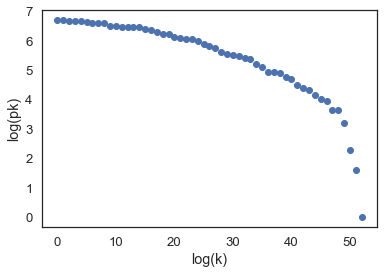

In [148]:
# Original network with no cutoff
scale_free_validate(tom_df)

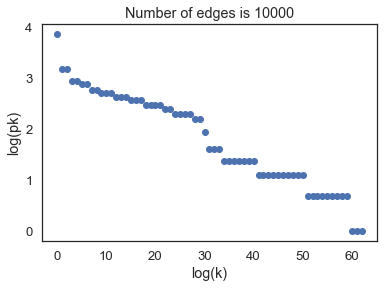

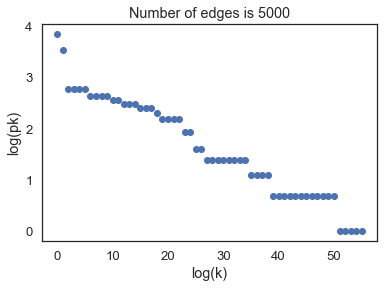

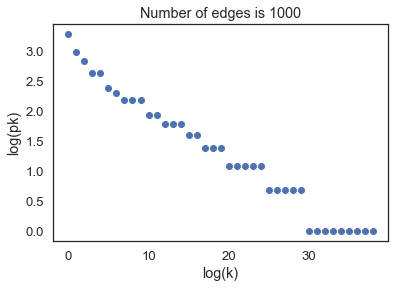

In [147]:
subset_networks = []
for edge in [10000,5000,1000]:
    subset, G = subset_network1(tom_df, 0.21, 0.99, edge)
    subset_networks.append(subset) # for community detection
    plt.title(f'Number of edges is {edge}')
    scale_free_validate(subset)

# Evaluation 2: compare network distance by GED and deltacon

## Note to use DeltaCon, the graphs need to have the same number of nodes so just replace edges with small weights with 0

In [21]:
def subset_network2(network_df, weight_min, weight_max):
    '''
    A function to subset a network using weight cutoff
    Return the adjacency matrix and the graph with the edges NOT removed from the cutoff to keep the same # nodes as the original graph so the graph distance could be compared
    '''
    subset = network_df[(network_df > weight_min) & (network_df < weight_max)]
    subset_adj = subset.stack() # convert from wide to long to determine # edges left
    print('Number of edges left:',len(subset_adj)/2)
    subset = subset.fillna(0)    
    G = nx.convert_matrix.from_pandas_adjacency(subset)
    return subset, G

In [3]:
def compare_graph_distance(network1, network2, metric = 'deltacon'):
    if metric == 'deltacon':
        dist_obj = netrd.distance.DeltaCon()
        return dist_obj.dist(network1, network2)
    else:
        return nx.graph_edit_distance(network1, network2)

In [26]:
def plot_graph_distance(networks, network_names):
    whole_network = tom_df.values
    dc_distance_list = []
    ged_distance_list = []
    
    for sub_network in networks:
        dc_distance_list.append(netcomp.deltacon0(whole_network, sub_network.values))
        ged_distance_list.append(netcomp.edit_distance(whole_network, sub_network.values))
    plt.figure(figsize = (10,5))
    plt.subplot(1,2,1)
    plt.bar(network_names, dc_distance_list)
    plt.title('Deltacon distance')
    plt.xlabel('Number of edges')
    plt.subplot(1,2,2)
    plt.bar(network_names, ged_distance_list)
    plt.title('GEM distance')
    plt.xlabel('Number of edges')
    plt.subplots_adjust(wspace = 0.5)

In [57]:
subset_networks2 = []
for weight in [0.218, 0.24, 0.278]:
    subset, G = subset_network2(tom_df, weight, 0.98)
    subset_networks2.append(subset)

Number of edges left: 10100.0
Number of edges left: 4967.0
Number of edges left: 1092.0


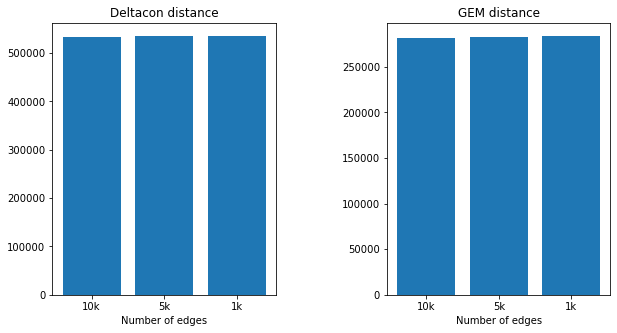

In [59]:
plot_graph_distance(subset_networks2, ['10k', '5k', '1k'])

# Evaluation 3: compare network modules by Jaccard

In [25]:
tom_df_subset = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\tom_subset.csv', index_col = 0)

In [205]:
def run_louvain(adjacency_df):
    # louvain communities
    louvain = Louvain(modularity = 'Newman')
    labels = louvain.fit_transform(adjacency_df.values) # using networkx community requires converting the df to G first and the original network takes very long but this method can work on df 
    louvain_df = pd.DataFrame({'id':adjacency_df.index, 'louvain_label':labels})
    return louvain_df

In [28]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1)) + len(set(list2)) - intersection
    return intersection / union

In [220]:
def community_jaccard(community_df1, community_df2, title, top = None):
    '''
    plot jaccard pairwise comparison on the communities in 2 networks
    title: main title for each plot
    top: top n comparison to show in the boxplot since it could be misleadingly small if we include all jaccard scores
    # we're only interested in the modules that have majority of the matching nodes between 2 networks
    '''
    c1_list = []
    c2_list = []
    j_list = []
    for c1 in community_df1.louvain_label.unique():
        for c2 in community_df2.louvain_label.unique():
            sub1 = community_df1[community_df1.louvain_label == c1].index
            sub2 = community_df2[community_df2.louvain_label == c2].index
            c1_list.append(c1)
            c2_list.append(c2)
            j_list.append(jaccard_similarity(sub1, sub2))
            
    jac_df = pd.DataFrame({'community1':c1_list, 'community2':c2_list, 'jaccard':j_list})
    jac_df = jac_df.pivot(index = 'community1', columns = 'community2', values = 'jaccard')
    sns.set(font_scale=1.2)
    sns.set_style('white')
    h = len(community_df1.louvain_label.unique())/2
    w = len(community_df2.louvain_label.unique())/2
    fig = plt.figure(figsize = (w, h))
    gs = gridspec.GridSpec(1,2, width_ratios = [3,1]) # set the subplot width ratio
    ax0 = plt.subplot(gs[0])
    # plot heatmap for pairwise jaccard comparison
    sns.heatmap(jac_df, cmap = 'Reds', xticklabels=True, yticklabels=True)
    plt.title('Jaccard pairwise module comparison')
    plt.xticks(rotation=0)
    ax1 = plt.subplot(gs[1])
    # boxplot of jaccard distribution
    all_jac_values = jac_df.values.flatten()
    if top != None:
        sorted_jac_values = sorted(all_jac_values, reverse = True)
        sns.boxplot(x= None, y = sorted_jac_values[:top])
    else:
        sns.boxplot(x= None, y = all_jac_values)
    plt.ylim(0,1)
    plt.title('Jaccard distribution')
    plt.suptitle(title)

In [214]:
original_community = run_louvain(tom_df)

In [149]:
for subset in subset_networks:
    subset_communities.append(run_louvain(subset))

### Louvain determined the original network had 10 modules only instead of the 26 in the paper but bc I don't know how to translate the method used in WCGNA to Python codes. All I know is WCGNA used hierarchical clustering unless I dig in to the codes or run the clustering on the subsets with WCGNA. For now, all the network modules are detected with louvain

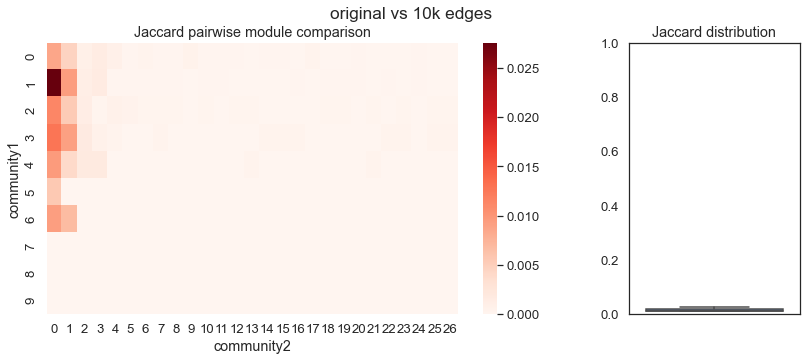

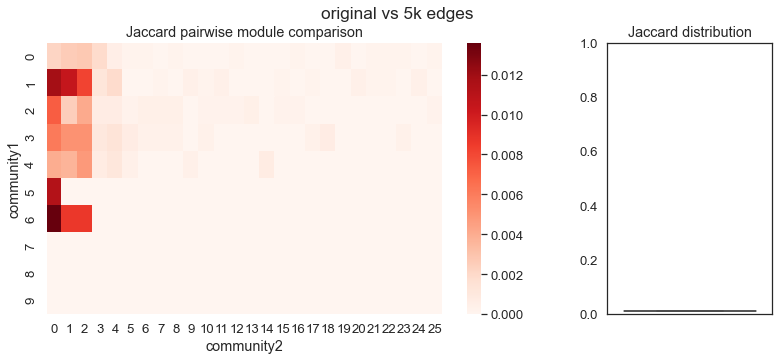

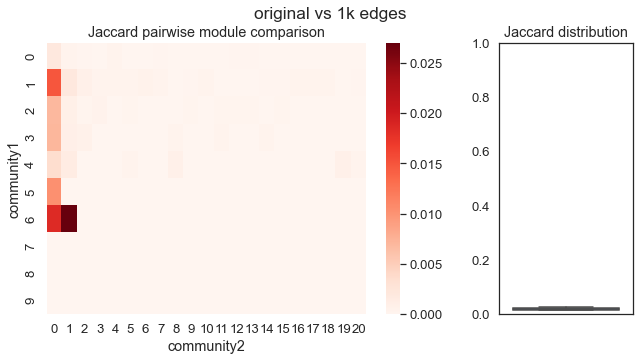

In [221]:
subset_names = ['10k edges', '5k edges', '1k edges']
for i, subset_com in enumerate(subset_communities):
    community_jaccard(original_community, subset_com, f'original vs {subset_names[i]}', top = 3)